# Training LSTM on residuals of physical model

In [3]:
from pathlib import Path
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Add src folder to Python path
sys.path.append(str(Path("../src").resolve()))

from data_generation import generate_data
from ode_model import LorenzModel
from lstm import WindowedTimeSeries, train_model, predict_autoregressive

Generate data
- 10,000 obs
- noise proportion = 0.05

In [4]:
n = 10000
noise_level = 0.05
time_step = 0.05

data = generate_data(n, noise_level=noise_level, time_step=time_step)

In [5]:
data.shape

(10000, 3)

Create imperfect Lorenz Model
- Set c = 13 (MSE LSTM aprrox = LSTM ODE)

In [6]:
ode_model = LorenzModel(c=13)

Predict k steps ahead using ODE model
- Compute residuals and inspect

In [7]:
k=10
preds_ode = ode_model.predict(y0=data, t_step=time_step*k)

In [8]:
true = data
true.shape

(10000, 3)

In [9]:
residuals_ode = true[k: , :] - preds_ode[:-k, :]

In [10]:
residuals_ode.shape

(9990, 3)

In [11]:
np.mean(residuals_ode ** 2)

22.46692758095521

In [12]:
np.mean(residuals_ode, axis=0)

array([-0.00690067, -0.03636735, -0.23475919])

In [13]:
residuals_ode.std(axis=0, ddof=1)

array([4.53201179, 5.10908668, 4.55073015])

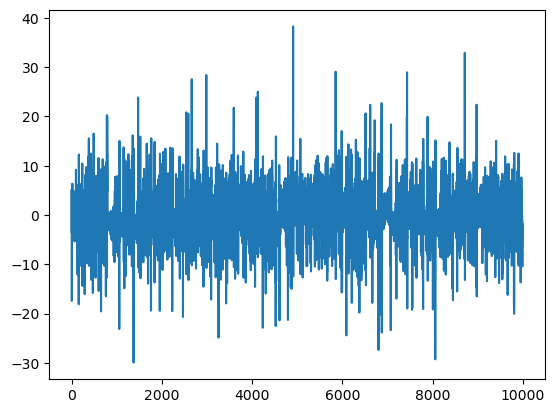

In [14]:
plt.plot(residuals_ode[:,0])
plt.show()

Train LSTM
- Split data into train and test
- convert data to custom class
- Train LSTM

In [24]:
input_series = true[:-k, ]
input_series.shape

(9990, 3)

In [16]:
train_length = int(residuals_ode.shape[0] * 0.8)
train_target_series = residuals_ode[:train_length, :]
test_target_series = residuals_ode[train_length:, :]
train_input_series = input_series[:train_length, :]
test_input_series = input_series[train_length:, :]

In [17]:
train_dataset = WindowedTimeSeries(train_input_series, train_target_series, 10)
test_dataset = WindowedTimeSeries(test_input_series, test_target_series, 10)

In [21]:
lstm_model = train_model(
  train_dataset=train_dataset,
  val_dataset=test_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=64,
  learning_rate=0.01,
  num_epochs=20,
)

Epoch [10/20], train_loss: 17.9075, val_loss: 16.7563
Epoch [20/20], train_loss: 17.4984, val_loss: 16.5354


In [22]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [23]:


all_preds = []
all_target = []
for X_batch, Y_batch in test_loader:
  preds = predict_autoregressive(lstm_model, X_batch, steps=1)
  all_preds.append(preds)
  all_target.append(Y_batch)


all_preds = torch.cat(all_preds)
all_target = torch.cat(all_target)

mse = nn.MSELoss()(all_preds, all_target)
print(f"MSE: {mse}")

MSE: 16.53537940979004


In [27]:
c_range = np.linspace(12,16,9)
k_range = [1,5,10,15,20]

for k in k_range:
  for c in c_range:
    ode_model.update_params(c=c)
    preds_ode = ode_model.predict(y0=data, t_step=time_step*k)
    true = data[:-k,]

    residuals_ode = data[k: , :] - preds_ode[:-k, :]
    train_length = int(residuals_ode.shape[0] * 0.8)
    train_target_series = residuals_ode[:train_length, :]
    test_target_series = residuals_ode[train_length:, :]
    train_input_series = true[:train_length, :]
    test_input_series = true[train_length:, :]

    train_dataset = WindowedTimeSeries(train_input_series, train_target_series, 10)
    test_dataset = WindowedTimeSeries(test_input_series, test_target_series, 10)

    lstm_model = train_model(
      train_dataset=train_dataset,
      val_dataset=test_dataset,
      hidden_size=100,
      num_layers=1,
      batch_size=64,
      learning_rate=0.01,
      num_epochs=20,
      silence=True
    )

    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    all_preds = []
    all_target = []
    for X_batch, Y_batch in test_loader:
      preds = predict_autoregressive(lstm_model, X_batch, steps=1)
      all_preds.append(preds)
      all_target.append(Y_batch)

    all_preds = torch.cat(all_preds)
    all_target = torch.cat(all_target)  

    mse = nn.MSELoss()(all_preds, all_target)
    print(f"k: {k}, c: {c:.2f}, MSE: {mse:.2f}")


k: 1, c: 12.00, MSE: 1.11
k: 1, c: 12.50, MSE: 1.10
k: 1, c: 13.00, MSE: 1.10
k: 1, c: 13.50, MSE: 1.10
k: 1, c: 14.00, MSE: 1.08
k: 1, c: 14.50, MSE: 1.08
k: 1, c: 15.00, MSE: 1.08
k: 1, c: 15.50, MSE: 1.08
k: 1, c: 16.00, MSE: 1.07
k: 5, c: 12.00, MSE: 2.01
k: 5, c: 12.50, MSE: 1.99
k: 5, c: 13.00, MSE: 1.87
k: 5, c: 13.50, MSE: 1.91
k: 5, c: 14.00, MSE: 1.86
k: 5, c: 14.50, MSE: 1.85
k: 5, c: 15.00, MSE: 1.88
k: 5, c: 15.50, MSE: 1.89
k: 5, c: 16.00, MSE: 1.90
k: 10, c: 12.00, MSE: 18.56
k: 10, c: 12.50, MSE: 16.83
k: 10, c: 13.00, MSE: 16.52
k: 10, c: 13.50, MSE: 16.32
k: 10, c: 14.00, MSE: 16.58
k: 10, c: 14.50, MSE: 16.37
k: 10, c: 15.00, MSE: 16.37
k: 10, c: 15.50, MSE: 16.39
k: 10, c: 16.00, MSE: 16.17
k: 15, c: 12.00, MSE: 45.69
k: 15, c: 12.50, MSE: 43.43
k: 15, c: 13.00, MSE: 38.89
k: 15, c: 13.50, MSE: 41.04
k: 15, c: 14.00, MSE: 39.69
k: 15, c: 14.50, MSE: 36.55
k: 15, c: 15.00, MSE: 37.63
k: 15, c: 15.50, MSE: 37.75
k: 15, c: 16.00, MSE: 36.04
k: 20, c: 12.00, MSE: 55.34
